## Anomaly detection and recommender systems

This exercise is described in [ex8.pdf](data/ml-ex8/ex8.pdf).

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import f1_score

%matplotlib inline

### Anomaly detection in 2D dataset

In [2]:
# Load example dataset (2D)
data = sio.loadmat('data/ml-ex8/ex8data1.mat')

In [3]:
# Training dataset (307 examples)
X = data['X']

# Validation dataset (307 examples and labels)
X_val = data['Xval']
y_val = data['yval'].ravel()

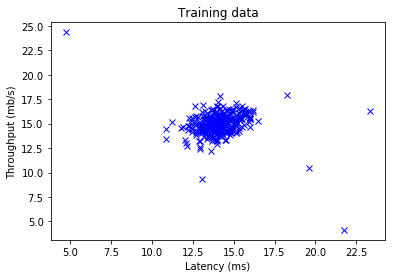

In [4]:
def plt_desc(title):
    plt.title(title)
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (mb/s)')    


# Plot training data
plt.plot(X[:,0], X[:,1], 'bx')
plt_desc('Training data')

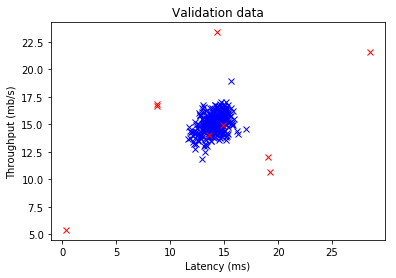

In [5]:
# Plot neg. validation data (label 0)
plt.plot(X_val[y_val == 0,0], X_val[y_val == 0,1], 'bx')
plt_desc('Validation data')

# Plot pos. validation data (label 1, anomalies)
plt.plot(X_val[y_val == 1,0], X_val[y_val == 1,1], 'rx');

#### Outlier detection approaches

To detect outliers in normally distributed data, two approaches are followed:

1. Fit a multivariate (2D) normal distribution to training data and evaluate that model for different values of `epsilon` with labeled validation data.

2. Fit a robust covariance estimate to the data with [EllipticEnvelope](http://scikit-learn.org/stable/modules/outlier_detection.html#fitting-an-elliptic-envelope) and evaluate that model for different values of the `contamination` hyper-parameter using labeled validation data.

##### Multivariate normal

In [6]:
# Fit a multivariate normal distribution using np.mean and np.cov
mvn = multivariate_normal(mean=np.mean(X, axis=0), cov=np.cov(X, rowvar=False))

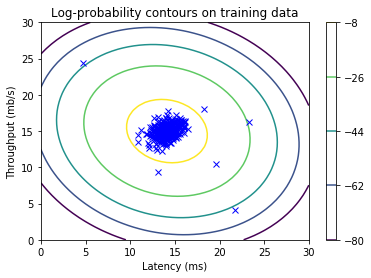

In [7]:
# Create a meshgrid and calculate grid scores for countour plot
x, y = np.meshgrid(np.linspace(0, 30), np.linspace(0, 30))
xx = np.array([x.ravel(), y.ravel()]).T
z = mvn.logpdf(xx).reshape(x.shape)

# Plot training data
plt.plot(X[:,0], X[:,1], 'bx')

# Plot log-probability contours on training data (see color bar for value range)
CS = plt.contour(x, y, z, levels=np.linspace(-80, -8, 5))
plt.colorbar(CS)
plt_desc('Log-probability contours on training data')

In [8]:
def estimate_epsilon(mvn, X_val, y_val):
    '''Estimate best epsilon from validation set log probabilities.
    
    This procedure chooses that epsilon value from a range of epsilon 
    values that maximizes the F1-score. 
    '''

    # Compute log probabilities for examples in validation set
    y_score = mvn.logpdf(X_val)
    y_score_min = y_score.min() + 1
    y_score_max = y_score.max()

    # Define a range of epsilon values for model evaluation. In 
    # contrast to the original exercise we use log-probabilities
    # for epsilon (instead of plain probability values).
    epsilon_range = np.linspace(y_score_min, y_score_max, 100)

    # Compute F1-scores for that range of epsilon values
    f1_scores = [f1_score(y_val, y_score < epsilon) for epsilon in epsilon_range]
    
    # Obtain index of maximum F1-score
    f1_max_idx = np.argmax(f1_scores)

    print(f'Best F1-score = {f1_scores[f1_max_idx]}')

    # Return the epsilon value that maximizes F1-score
    return epsilon_range[f1_max_idx]

In [9]:
# Epsilon estimate (log-probability)
epsilon = estimate_epsilon(mvn, X_val, y_val)
epsilon

Best F1-score = 0.8750000000000001


-9.5779690318517936

In [10]:
# exp(epsilon) estimate (probability)
np.exp(epsilon)

6.9237424029420396e-05

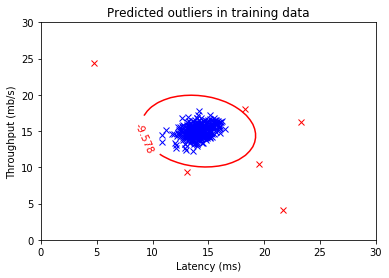

In [11]:
# Predict outliers in training data
y_outlier = mvn.logpdf(X) < epsilon
y_outlier_neg = np.logical_not(y_outlier)

# Plot training data with predicted outliers in red
plt.plot(X[y_outlier_neg, 0], X[y_outlier_neg, 1], 'bx')
plt.plot(X[y_outlier, 0], X[y_outlier, 1], 'rx')


# Plot contour for best epsilon on training data
CS = plt.contour(x, y, z, levels=[epsilon], colors='r', linestyles='solid')
plt.clabel(CS)
plt_desc('Predicted outliers in training data')

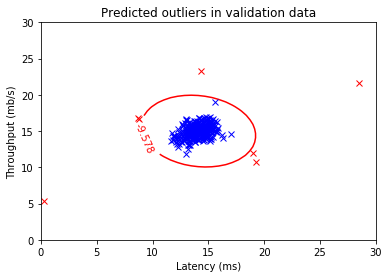

In [12]:
# Predict outliers in validation data
y_outlier = mvn.logpdf(X_val) < epsilon
y_outlier_neg = np.logical_not(y_outlier)

# Plot validation data with predicted outliers in red
plt.plot(X_val[y_outlier_neg, 0], X_val[y_outlier_neg, 1], 'bx')
plt.plot(X_val[y_outlier, 0], X_val[y_outlier, 1], 'rx')

# Plot contour for best epsilon on validation data
CS = plt.contour(x, y, z, levels=[epsilon], colors='r', linestyles='solid')
plt.clabel(CS)
plt_desc('Predicted outliers in validation data')

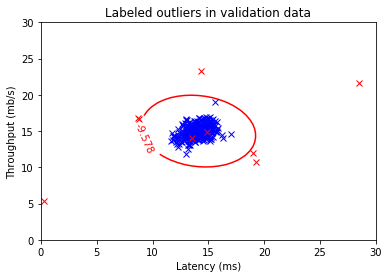

In [13]:
# Use outlier labels in validation data
y_outlier = y_val == 1
y_outlier_neg = np.logical_not(y_outlier)

# Plot validation data with labeled outliers in red
plt.plot(X_val[y_outlier_neg, 0], X_val[y_outlier_neg, 1], 'bx')
plt.plot(X_val[y_outlier, 0], X_val[y_outlier, 1], 'rx')

# Plot contour for best epsilon on validation data
CS = plt.contour(x, y, z, levels=[epsilon], colors='r', linestyles='solid')
plt.clabel(CS)
plt_desc('Labeled outliers in validation data')

##### Elliptic envelope

In [14]:
# EllipticEnvelope model object with default value 
# for contamination parameter. Contamination is the 
# proportion of outliers in the data set.
model = EllipticEnvelope(contamination=0.1)

# We will choose that contamination parameter that
# maximizes the F1-score on the validation dataset.
# Define 10 contaminations within range [0.005, 0.05]:
contaminations = np.linspace(0.005, 0.05, 10)

In [15]:
# List of F1-scores
f1_scores = []

# Evaluate model for different contaminations
for contamination in contaminations:
    # Update contamination hyper-parameter
    model.contamination = contamination
    # fit model to training data
    model.fit(X)
    # predict outliers (value == -1)
    y_pred = model.predict(X_val)
    # compute F1-score from prediction
    f1 = f1_score(y_val == 1, y_pred == -1)
    f1_scores.append(f1)

In [16]:
# Obtain index of maximum F1-score
f1_max_idx = np.argmax(f1_scores)

# Obtain the contamination value that maximizes F1-score
contamination = contaminations[f1_max_idx]

In [17]:
# Best F1-score
f1_scores[f1_max_idx]

0.87500000000000011

In [18]:
# Contamination estimate
contaminations[f1_max_idx]

0.015000000000000003

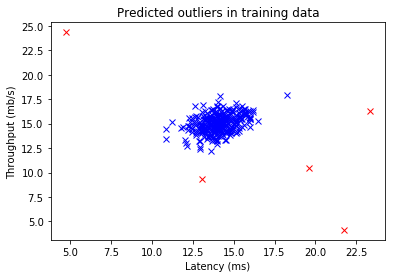

In [19]:
# Re-fit model with best contamination_score
model.contamination = contamination
model.fit(X)

# Predict outliers in training data
y_pred = model.predict(X)

# Plot predicted outliers in training data
plt.plot(X[y_pred == 1,0], X[y_pred == 1,1], 'bx')
plt.plot(X[y_pred == -1,0], X[y_pred == -1,1], 'rx')
plt_desc('Predicted outliers in training data')

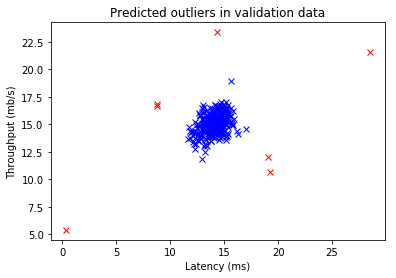

In [20]:
# Predict outliers in validation data
y_pred = model.predict(X_val)

# Plot predicted outliers in validation data
plt.plot(X_val[y_pred == 1,0], X_val[y_pred == 1,1], 'bx')
plt.plot(X_val[y_pred == -1,0], X_val[y_pred == -1,1], 'rx')
plt_desc('Predicted outliers in validation data')

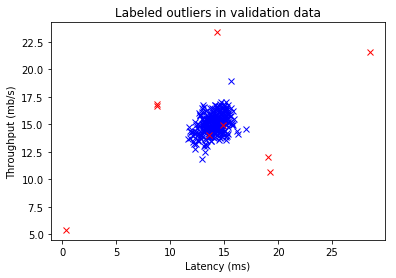

In [21]:
# Plot labeled outliers in validation data
plt.plot(X_val[y_val == 0,0], X_val[y_val == 0,1], 'bx')
plt.plot(X_val[y_val == 1,0], X_val[y_val == 1,1], 'rx')
plt_desc('Labeled outliers in validation data')

### Anomaly detection in high-dimensional dataset

Here, we fit a multivariate normal to a higher-dimensional dataset.

In [22]:
# Load example dataset (high-dimensional)
data = sio.loadmat('data/ml-ex8/ex8data2.mat')

In [23]:
# Training dataset (1000 examples)
X = data['X']

# Validation dataset (100 examples and labels)
X_val = data['Xval']
y_val = data['yval'].ravel()

In [24]:
# Fit a multivariate normal distribution using np.mean and np.cov
mvn = multivariate_normal(mean=np.mean(X, axis=0), cov=np.cov(X, rowvar=False))

In [25]:
# Epsilon estimate (log-probability)
epsilon = estimate_epsilon(mvn, X_val, y_val)
epsilon

Best F1-score = 0.7499999999999999


-47.829768268123146

In [26]:
# exp(epsilon) estimate (probability)
np.exp(epsilon)

1.6896454005370627e-21

### Recommender systems

This section uses [polylearn](http://contrib.scikit-learn.org/polylearn/), a [scikit-learn-contrib](https://github.com/scikit-learn-contrib/scikit-learn-contrib/blob/master/README.md) project, for collaborative filtering. Polylearn provides an implementation of [factorization machines](https://www.ismll.uni-hildesheim.de/pub/pdfs/Rendle2010FM.pdf) which is exactly what we need for low-rank matrix factorization. We will use [`polylearn.FactorizationMachineRegressor`](http://contrib.scikit-learn.org/polylearn/generated/polylearn.FactorizationMachineRegressor.html#polylearn.FactorizationMachineRegressor) for making rating predictions and rankings from sparse movie rating data.

In [27]:
import csv
import re

from polylearn import FactorizationMachineRegressor
from scipy.sparse import coo_matrix

In [28]:
# Load movie rating dataset (1682 movies rated by 943 users)
movies = sio.loadmat('data/ml-ex8/ex8_movies.mat')

# Load movie names and add them to the movie_names list. List 
# indices corresponds to the movie ids used in movies dataset.
with open('data/ml-ex8/movie_ids.txt', encoding='latin_1') as f:
    movie_names = [re.split(r'^\d+ (.*)', line)[1] for line in f]
    
# Convert list of movie names to a numpy array for more 
# flexible indexing (later).
movie_names = np.array(movie_names)    

In [29]:
# 1682*943 matrix with user ratings (1-5).
Y = movies['Y']

# 1682*943 indicator matrix. R[i,j] == 1
# if user j rated for movie i, 0 otherwise.
R = movies['R']

In [30]:
# The original course exercise adds one extra user 
# for making movie recommendations to that user.
y_extra = np.zeros(Y.shape[0], dtype=np.uint8)
r_extra = np.zeros(R.shape[0], dtype=np.uint8)

def add_rating(movie_id, rating):
    y_extra[movie_id] = rating; r_extra[movie_id] = 1    

# We use the very same ratings as in the original course 
# exercise so that recommendations are comparable. See 
# also file ex8_cofi.m in the original course material.
add_rating(0, 4)    
add_rating(6, 3)    
add_rating(11, 5)    
add_rating(53, 4)    
add_rating(63, 5)    
add_rating(65, 3)    
add_rating(68, 5)    
add_rating(97, 2)    
add_rating(182, 4)    
add_rating(225, 5)    
add_rating(354, 5)    

In [31]:
# Show ratings made by that extra user
for (m, r) in zip(movie_names[r_extra == 1], y_extra[r_extra == 1]):
    rs = '*' * r
    print(f'{m:<35s} {rs}')

Toy Story (1995)                    ****
Twelve Monkeys (1995)               ***
Usual Suspects, The (1995)          *****
Outbreak (1995)                     ****
Shawshank Redemption, The (1994)    *****
While You Were Sleeping (1995)      ***
Forrest Gump (1994)                 *****
Silence of the Lambs, The (1991)    **
Alien (1979)                        ****
Die Hard 2 (1990)                   *****
Sphere (1998)                       *****


In [32]:
# Add these ratings to the other ratings
Y = np.c_[Y, y_extra]
R = np.c_[R, r_extra]

In [33]:
# Number of movies and users
num_movies, num_users = Y.shape
num_movies, num_users

(1682, 944)

In [34]:
# Number of ratings made by all users
num_ratings = np.count_nonzero(R)
num_ratings

100011

In [35]:
# In order to use FactorizationMachineRegressor, we need to 
# encode each rating as separate (sparse) feature vector. A 
# feature vector x has num_movies + num_users features, one
# for each movie and one for each user. 
num_features = num_movies + num_users
num_features

# When user j rates movie i then x[i] = x[j] = 1, all other 
# features in x are not set. The following creates the row-
# and column-index arrays needed to create a sparse matrix.
row_indices = np.repeat(np.arange(num_ratings), 2)
col_indices = np.zeros(num_ratings * 2)

for i, (m, u) in enumerate(np.argwhere(R)):
    col_indices[2*i] = m
    col_indices[2*i+1] = u + num_movies

# Given num_ratings, we get a design matrix X of shape 
# (num_ratings, num_features). X is a sparse matrix.
X = coo_matrix((np.ones(num_ratings * 2), (row_indices, col_indices)), 
               shape=(num_ratings, num_features), dtype=np.int8)

# Target vector y has shape (num_ratings,) and contains 
# the actual ratings (1-5).
y = Y[R==1]

In [36]:
# Create a factorization machine object and define a 
# limit for the size of the resulting factor vectors 
# (n_components = 2).
fm = FactorizationMachineRegressor(n_components=2, fit_linear=False, random_state=0)

# Compute the factor vectors.
fm.fit(X, y)

FactorizationMachineRegressor(alpha=1, beta=1, degree=2, fit_linear=False,
               fit_lower='explicit', init_lambdas='ones', max_iter=10000,
               n_components=2, random_state=0, tol=1e-06, verbose=False,
               warm_start=False)

In [37]:
# Obtain the factor vectors for all movies
F_movies = fm.P_[0][:,:num_movies]

# Obtain the factor vectors for all users
F_users = fm.P_[0][:,num_movies:]

In [38]:
# Predict ratings the extra user would give to all movies by 
# calculating the scalar product of the user factor vector 
# with all movie factor vectors.
y_pred = F_movies.T.dot(F_users[:,-1])

In [39]:
# Number of recommendations to display
rec_num = 15

# List the top rec_num movies recommended to the extra user
# including the recommendation scores. These scores equal the
# predicted ratings.
rec_movies = movie_names[np.argsort(y_pred)[::-1]][:rec_num]
rec_score = np.sort(y_pred)[::-1][:rec_num]

for (m, s) in zip(rec_movies, rec_score):
    print(f'{s:1.2f}: {m}')

4.61: Titanic (1997)
4.53: Raiders of the Lost Ark (1981)
4.52: Shawshank Redemption, The (1994)
4.49: Schindler's List (1993)
4.46: Braveheart (1995)
4.40: Good Will Hunting (1997)
4.38: Star Wars (1977)
4.34: It's a Wonderful Life (1946)
4.33: As Good As It Gets (1997)
4.28: Hunt for Red October, The (1990)
4.27: Terminator 2: Judgment Day (1991)
4.27: Empire Strikes Back, The (1980)
4.26: Indiana Jones and the Last Crusade (1989)
4.25: Fugitive, The (1993)
4.25: Great Escape, The (1963)


The same recommendations can also be generated by first creating features vectors `x` for all user-movie interactions of interest and then calling `fm.predict` with a design matrix `X` containing these feature vectors as row vectors. This is actually the recommended way as the above approach i.e. using the dot products of factor vectors directly only works when `fit_linear=False`. 

Our movie recommendations closely match those of the original exercise:

    Top recommendations for you:
    ... Star Wars (1977)
    ... Titanic (1997)
    ... Shawshank Redemption, The (1994)
    ... Raiders of the Lost Ark (1981)
    ... Schindler's List (1993)
    ... Empire Strikes Back, The (1980)
    ... Good Will Hunting (1997)
    ... Godfather, The (1972)
    ... Wrong Trousers, The (1993)
    ... Braveheart (1995)

In [40]:
# In addition to making predictions and recommendations 
# for a given user, we can also compare movies directly 
# by calculating the euclidean distances of their factor 
# vectors. For example, movies in the following list have
# the smalled distances (in ascending order) to movie 49
# which is "Star Wars (1977)"
distances = np.linalg.norm(F_movies.T - F_movies.T[49], axis=1)
for i in movie_names[np.argsort(distances)][1:15]:
    print(i)

Good Will Hunting (1997)
Schindler's List (1993)
Shawshank Redemption, The (1994)
Empire Strikes Back, The (1980)
Princess Bride, The (1987)
Great Escape, The (1963)
As Good As It Gets (1997)
Glory (1989)
Sting, The (1973)
Some Folks Call It a Sling Blade (1993)
Much Ado About Nothing (1993)
Day the Earth Stood Still, The (1951)
Fresh (1994)
Searching for Bobby Fischer (1993)


In [41]:
# In the same way as movies can be compared, users can 
# also be compared calculating the euclidean distances 
# of their factor vectors (not shown here ...)